<a href="https://colab.research.google.com/github/alanflorendo/building_micrograd/blob/main/01_building_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np

In [15]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0 # initially assume there is no effect on the loss function
    self._backward = lambda: None # base case: this does nothing (eg, for a leaf node)
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [3]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

In [5]:
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    
    # for any value in the graph, create a rectangle ('record') node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [6]:
# backwards propogate grads, manually for now
L.grad = 1

# f & d are mult ops--> each affects L by the actual value of the other
# but see a&b below... we need the chain rule here, except that L.grad is 1, so it doesn't affect us here
f.grad = d.data * 1
d.grad = f.data * 1

# c & e are add ops--> each affects L by the grad of d
c.grad = d.grad
e.grad = d.grad

# a & b are mult ops--> each affects L by its own data/value * the grad of its child
# aka chain rule
a.grad = a.data * e.grad
b.grad = b.data * e.grad


In [7]:
assert(-4.0 == a.grad)
assert(6.0 == b.grad)
assert(-2.0 == c.grad)
assert(-2.0 == d.grad)
assert(-2.0 == e.grad)
assert(4.0 == f.grad)
assert(1.0 == L.grad)


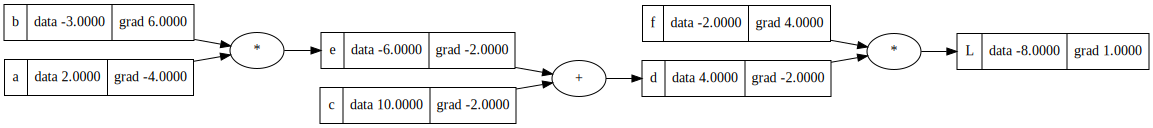

In [8]:
draw_dot(L)

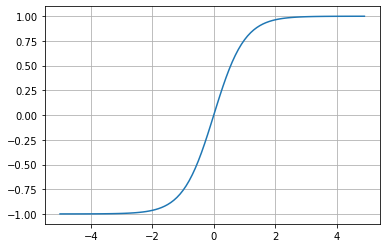

In [9]:
# tanh visual
import matplotlib.pyplot as plt

xs = np.arange(-5, 5, 0.1)
ys = np.tanh(xs)
plt.plot(xs, ys)
plt.grid()

In [16]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'


In [17]:
o.backward()

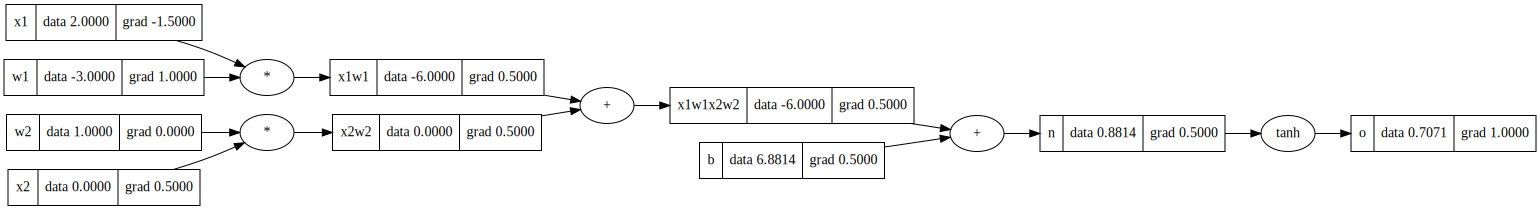

In [18]:
draw_dot(o)

In [19]:
def assertAlmostEqual(exp, act):
  if not (-0.00001 < (exp - act) < 0.00001):
    num_failing_tests += 1

assertAlmostEqual(x1.grad, -1.5)
assertAlmostEqual(w1.grad, 1.0)
assertAlmostEqual(x2.grad, 0.5)
assertAlmostEqual(w2.grad, 0.0)
assertAlmostEqual(x1w1.grad, 0.5)
assertAlmostEqual(x2w2.grad, 0.5)
assertAlmostEqual(x1w1x2w2.grad, 0.5)
assertAlmostEqual(b.grad, 0.5)
assertAlmostEqual(n.grad, 0.5)
assertAlmostEqual(o.grad, 1.0)

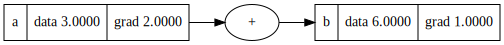

In [20]:
# DEMO OF BUG:
#  -- the problem arises when we use a variable more than once
#  -- a's grad should be 2: if you double a, b will b double
# -- the solution is that we need to accumulate (not override) these gradients

a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)